In [56]:
from matplotlib import pyplot as plt
import numpy as np, pandas as pd, seaborn as sns
import os, json

In [57]:
with open('../../config.json') as file:
    DNAME_OUT = json.load(file)['outdir']

read_csv = lambda x, **k: pd.read_csv(os.path.join(DNAME_OUT, x + '_final.csv'), **k)
runs, timing = read_csv('runs'), read_csv('timing')
df = pd.merge(runs, timing, on='run')
runs = runs.set_index('run')

In [58]:
def encode(df, col, vals):
    unq = df[col].unique()
    return df[col].replace(dict(zip(unq, vals[:len(unq)])))

Text(0, 0.5, 'Time searching queries (s)')

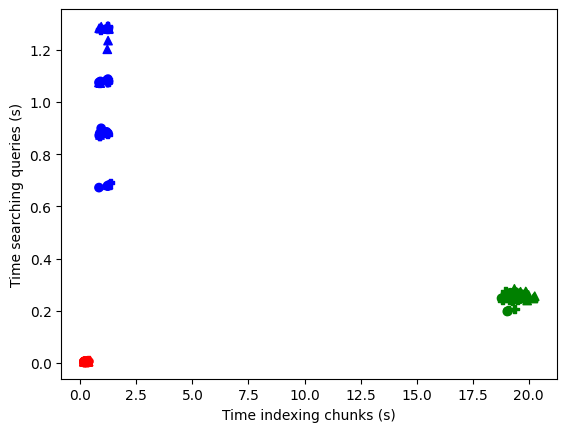

In [59]:
fig, ax = plt.subplots()

gb = df[df['part'] != 'embed'].groupby(['run', 'db', 'llm', 'process'])
_df = gb.duration.sum().unstack().reset_index().set_index('run')
_df['chunk_size'] = runs['chunk_size']
_df['color'] = encode(_df, 'db', 'rgb')
_df['marker'] =  encode(_df, 'chunk_size', ('^', 'P', 'o'))
for marker, mdf in _df.groupby('marker'):
    ax.scatter(mdf['index'], mdf.search, c=mdf.color, marker=marker)

ax.set_xlabel('Time indexing chunks (s)')
ax.set_ylabel('Time searching queries (s)')

In [60]:
colors = dict(_df[['db', 'color']].value_counts().index)
markers = dict(_df[['chunk_size', 'marker']].value_counts().index)
print(colors, markers, sep='\n')

{'chroma': 'g', 'milvus': 'b', 'redis': 'r'}
{200: '^', 500: 'P', 1000: 'o'}


Text(0, 0.5, 'Time embedding queries (s)')

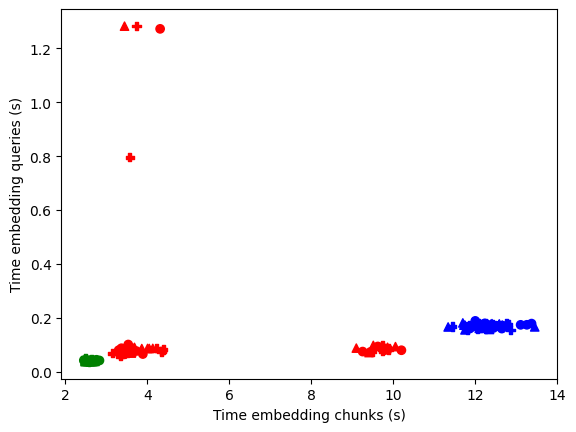

In [65]:
fig, ax = plt.subplots()

gb = df[df['part'] == 'embed'].groupby(['run', 'db', 'llm', 'process'])
_df = gb.duration.sum().unstack().reset_index().set_index('run')
_df['chunk_size'] = runs['chunk_size']
_df['chunk_overlap'] = runs['chunk_overlap']
_df['embedding_model'] = runs['embedding_model']
_df['color'] = encode(_df, 'embedding_model', 'rgb')
_df['marker'] =  encode(_df, 'chunk_overlap', ('^', 'P', 'o'))
for marker, mdf in _df.groupby('marker'):
    scatter = ax.scatter(mdf['index'], mdf.search, c=mdf.color, marker=marker)

ax.set_xlabel('Time embedding chunks (s)')
ax.set_ylabel('Time embedding queries (s)')

In [62]:
colors = dict(_df[['embedding_model', 'color']].value_counts().index)
markers = dict(_df[['chunk_size', 'marker']].value_counts().index)
print(colors, markers, sep='\n')

{'all-MiniLM-L6-v2': 'g', 'all-mpnet-base-v2': 'b', 'nomic-embed-text': 'r'}
{200: '^', 500: 'P', 1000: 'o'}


Text(0, 0.5, 'Memory Usage (MB)')

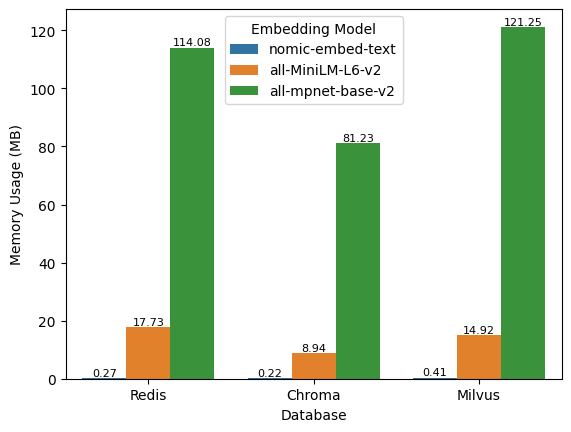

In [63]:
_runs = runs.copy()
_runs['Embedding Model'] = _runs.embedding_model
_runs['Database'] = _runs.db.apply(str.title)

ax = sns.barplot(_runs, x='Database', y='memory_peak_wset', hue='Embedding Model', estimator='mean', errorbar=None)
for i in range(3): ax.bar_label(ax.containers[i], fontsize=8, fmt='%.2f')
plt.ylabel('Memory Usage (MB)')

Text(0, 0.5, 'Average Time Elapsed (s)')

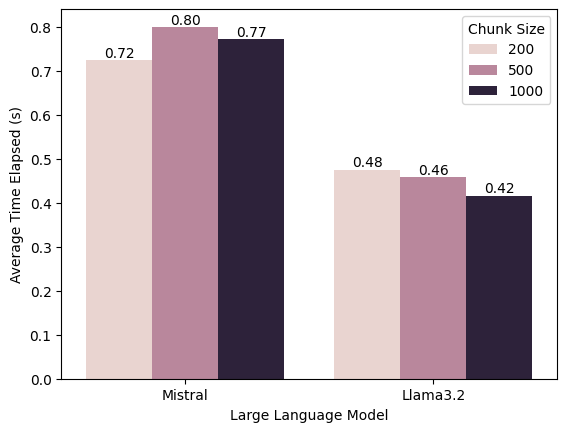

In [64]:
responses = read_csv('responses', on_bad_lines='skip')
for i, row in responses.iterrows():
    try: int(row['run']), float(row['duration'])
    except: responses = responses.drop(i)
responses.duration = responses.duration.astype(np.float64)
run_idx = responses.run.astype(int).tolist()
responses['Chunk Size'] = runs.chunk_size.loc[run_idx].tolist()
responses['Chunk Overlap'] = runs.chunk_overlap.loc[run_idx].tolist()
responses['Large Language Model'] = runs.llm.apply(str.title).loc[run_idx].tolist()

concat = lambda x: ','.join(map(str, x))
responses['Chunk Size, Overlap'] = responses[['Chunk Size', 'Chunk Overlap']].agg(concat, axis=1)

ax = sns.barplot(responses, x='Large Language Model', y='duration', hue='Chunk Size', estimator='mean', errorbar=None)
for i in range(3): ax.bar_label(ax.containers[i], fontsize=10, fmt='%.2f')
plt.ylabel('Average Time Elapsed (s)')